In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from IPython.display import display, Latex
import pycbc
from pycbc.waveform import get_td_waveform
from scipy.interpolate import interp1d
import sys
sys.path.append('/home/anirudh.nemmani/git_repos/teobresums/Python/') #TEOBResumS module path
import EOBRun_module
sys.path.append('/home/anirudh.nemmani/git_repos/gweat/src/') #GWEAT module path
import TEOBResumS_utils as ecc_gen
import eccentric_source as ecc_sou
from pesummary.io import read

sys.path.append('/home/anirudh.nemmani/git_repos/GWMAT/src/') # GWMAT module path
import py_lgw
lgw = py_lgw.lensed_wf_gen()

In [2]:
# Reading GW150914 parameters

gw150914 = read('../imrct/ground-150914/data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5') # Path to GWTC posterior samples
gw150914_result = gw150914.samples_dict['C01:IMRPhenomXPHM']
gw150914_pe_res = dict()
idx = np.argmax(gw150914_result['log_likelihood'])
for key in gw150914_result.keys():
            val = gw150914_result[key][idx]
            gw150914_pe_res[key] = np.float64(val)

2023-09-04  19:43:07 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2023-09-04  19:43:07 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2023-09-04  19:43:07 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


In [3]:
# Converting j-frame to l-frame
# Tilts are taken to be zero which is default in GWMAT
spins = lgw.jframe_to_l0frame(gw150914_pe_res['mass_1'], gw150914_pe_res['mass_2'], 20, phi_ref=gw150914_pe_res['phase'], 
                             theta_jn = gw150914_pe_res['theta_jn'], phi_jl=gw150914_pe_res['phi_jl'],
                             a_1=gw150914_pe_res['a_1'], a_2=gw150914_pe_res['a_2'], phi_12 = gw150914_pe_res['phi_12'])

for keys in spins.keys():
    print('%s : %s'%(keys, spins[keys]))

inclination : 2.491015454676615
spin1x : -0.0
spin1y : 0.0
spin1z : 0.8608417198511092
spin2x : -0.0
spin2y : 0.0
spin2z : 0.7195088134379835


# Defining parameters for waveform generation

In [4]:
sampling_frequency = 4096
f_start = 8  # starting frequency of WF, i.e., (2,2) mode of the WF.
f_low = 20    # Lower frequency from where SNR will be computed. It should satisfy the condition, f_start <= f_low, for it to make sense.
f_ref = 20.
f_high = None
# df = 0.007768570860783086 
init_pars = dict(f_start=f_start, f_low=f_low, f_high=f_high, f_ref=f_ref, sample_rate=sampling_frequency, ifo_list=['H1','L1'], wf_approximant='IMRPhenomXPHM')

cbc_pars = dict(mass_1=gw150914_pe_res['mass_1'], mass_2=gw150914_pe_res['mass_2'], chi1z=0, chi2z=0, 
              inclination=spins['inclination'], coa_phase=gw150914_pe_res['phase'], polarization=gw150914_pe_res['psi'], ra=gw150914_pe_res['ra'], dec=gw150914_pe_res['dec'], 
              luminosity_distance=gw150914_pe_res['luminosity_distance'], trigger_time=gw150914_pe_res['geocent_time'],
              ecc=0.2)
#psd_pars = dict(Noise=False, gen_seed=10, psd_L1='O4')

prms = {**init_pars, **cbc_pars}#, **psd_pars
pars = ecc_gen.teobresums_pars_update(prms)

# Generating non-eccentric waveform using the approximant IMRPhenomXPHM, to have it as a basline

In [5]:
t_hp, t_hc = get_td_waveform(
            approximant = pars['wf_approximant'],
            mass1 = pars['mass_1'],
            mass2 = pars['mass_2'],
            spin1x = 0,
            spin1y = 0,
            spin1z = 0,
            spin2x = 0,
            spin2y = 0,
            spin2z = 0,
            lambda1 = 0,
            lambda2 = 0,
            distance =  pars['luminosity_distance'],
            inclination = pars['inclination'],
            coa_phase = pars['coa_phase'],
            mode_array = pars['mode_array'],
            f_lower = pars['f_low'],
            f_ref = pars['f_ref'],
            delta_t = 1./pars['sample_rate'])

f_hp = t_hp.to_frequencyseries(delta_f=t_hp.delta_f)
f_hc = t_hc.to_frequencyseries(delta_f=t_hc.delta_f)

non_eccentric_t_hp = t_hp
non_eccentric_t_hc = t_hc

non_eccentric_f_hp = f_hp
non_eccentric_f_hc = f_hc

In [6]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(non_eccentric_t_hp.sample_times, non_eccentric_t_hp, label=r'$h_{+}$')
sub_figure_1.plot(non_eccentric_t_hc.sample_times, non_eccentric_t_hc, label=r'$h_{\times}$')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_xlim(-1.5, 0.5)
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(non_eccentric_f_hp.sample_frequencies, np.abs(non_eccentric_f_hp), label=r'$h_{+}$')
sub_figure_2.loglog(non_eccentric_f_hc.sample_frequencies, np.abs(non_eccentric_f_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(non_eccentric_f_hp.sample_frequencies, np.angle(non_eccentric_f_hp), label=r'$h_{+}$')
sub_figure_3.plot(non_eccentric_f_hc.sample_frequencies, np.angle(non_eccentric_f_hc), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Waveform plots of non spinning GW150914 non-eccentric waveform IMRPhenomXPHM')

Text(0.5, 0.98, 'Waveform plots of non spinning GW150914 non-eccentric waveform IMRPhenomXPHM')

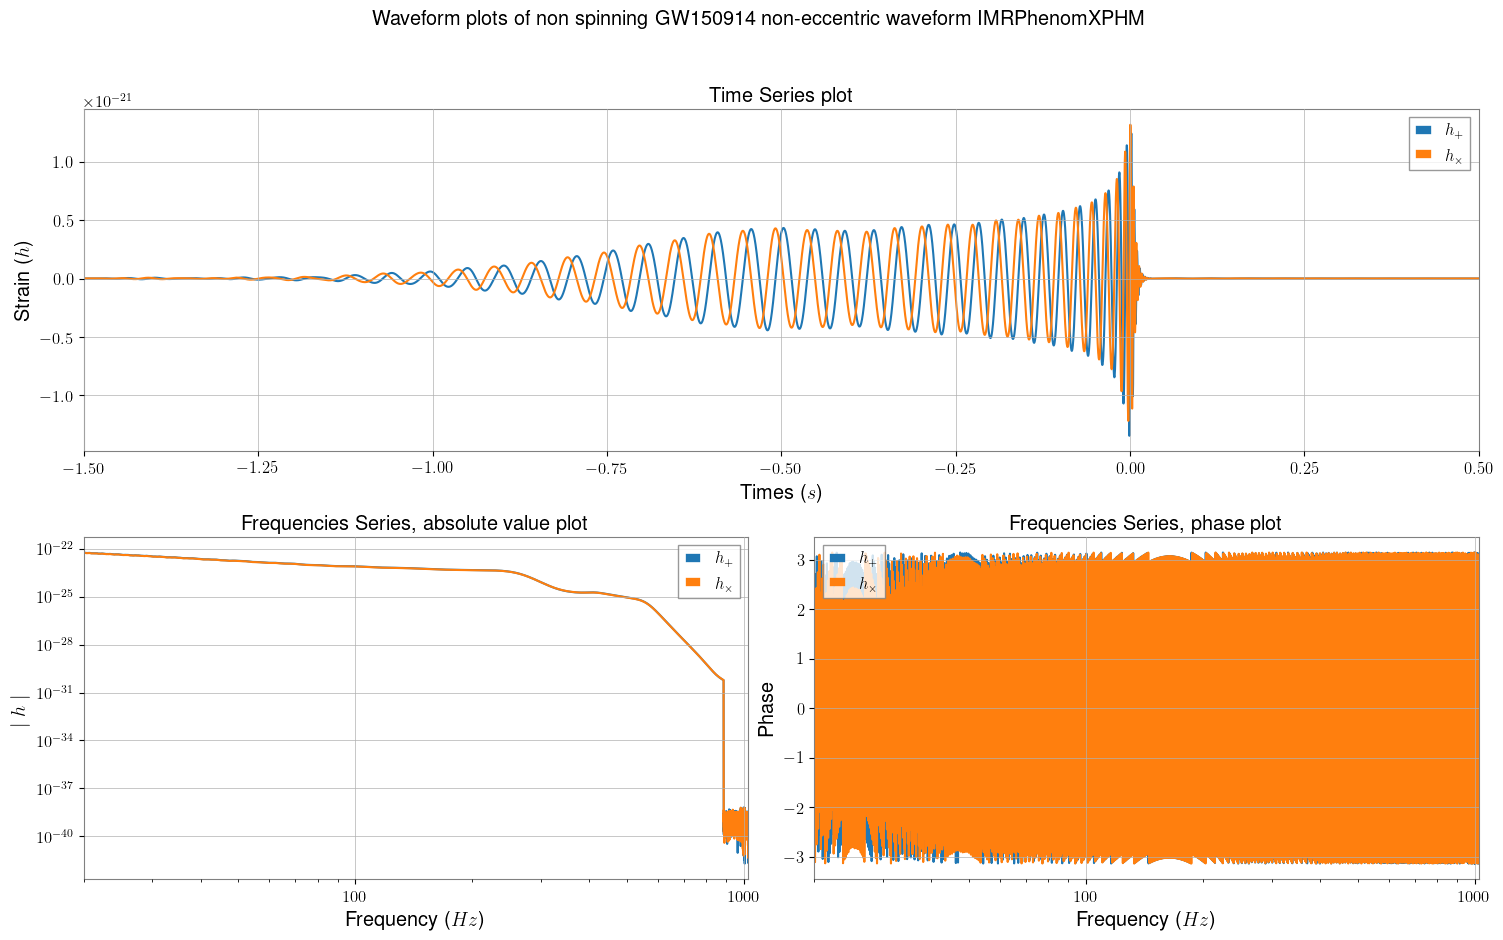

In [7]:
plt.show()

<font size="5"> Let's interpolate the frequency series with just normal strain and frequency array </font>

In [8]:
#Frequency vector
frequency_vector = np.arange(0, 1024, 0.01)

In [9]:
strain_array_hp = np.array(f_hp, dtype=np.complex128)
strain_array_hc = np.array(f_hc, dtype=np.complex128)

Interpolating function

In [10]:
if_hp = interp1d(f_hp.sample_frequencies[:], strain_array_hp[:], kind='linear')
if_hc = interp1d(f_hc.sample_frequencies[:], strain_array_hc[:], kind='linear')

Interpolating to the new frequency vector and concating it

In [11]:
interpolated_hp = np.concatenate(([0], if_hp(frequency_vector[1:])))
interpolated_hc = np.concatenate(([0], if_hc(frequency_vector[1:])))

In [12]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
interpolated_hp *= frequency_bounds
interpolated_hc *= frequency_bounds

In [13]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_hp), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_hc), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated_hp), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

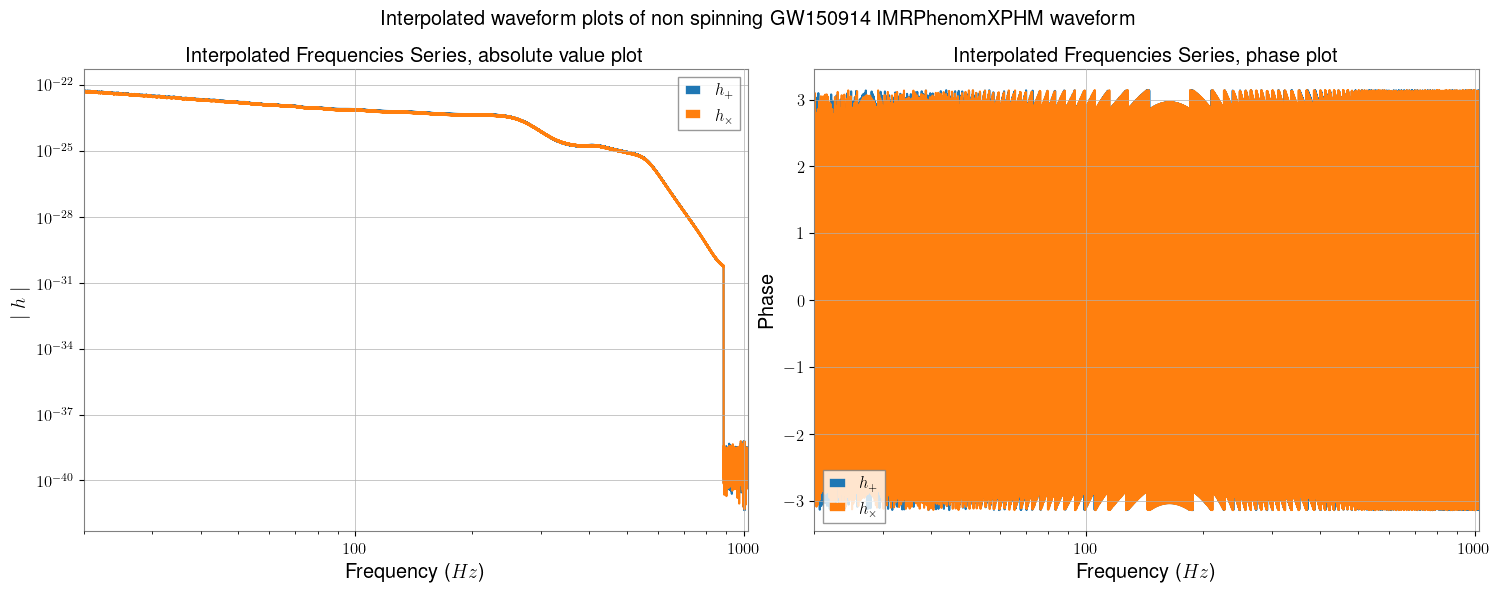

In [14]:
plt.show()

# Let's do the same interpolation in log series strain

In [15]:
log_strain_array_hp = np.log10(np.array(f_hp, dtype=np.complex128))
log_strain_array_hc = np.log10(np.array(f_hc, dtype=np.complex128))

/tmp/ipykernel_16956/752853974.py:1: RuntimeWarning: divide by zero encountered in log10
  log_strain_array_hp = np.log10(np.array(f_hp, dtype=np.complex128))
/tmp/ipykernel_16956/752853974.py:2: RuntimeWarning: divide by zero encountered in log10
  log_strain_array_hc = np.log10(np.array(f_hc, dtype=np.complex128))


In [16]:
log_if_hp = interp1d(f_hp.sample_frequencies[:], log_strain_array_hp[:], kind='linear')
log_if_hc = interp1d(f_hc.sample_frequencies[:], log_strain_array_hc[:], kind='linear')

In [23]:
log_interpolated_hp = np.concatenate(([0], 10**log_if_hp(frequency_vector[1:])))
log_interpolated_hc = np.concatenate(([0], 10**log_if_hc(frequency_vector[1:])))

In [24]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
log_interpolated_hp *= frequency_bounds
log_interpolated_hc *= frequency_bounds

In [25]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(log_interpolated_hp), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(log_interpolated_hc), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(log_interpolated_hp), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(log_interpolated_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Log strain interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Log strain interpolated waveform plots of non spinning GW150914 IMRPhenomXPHM waveform')

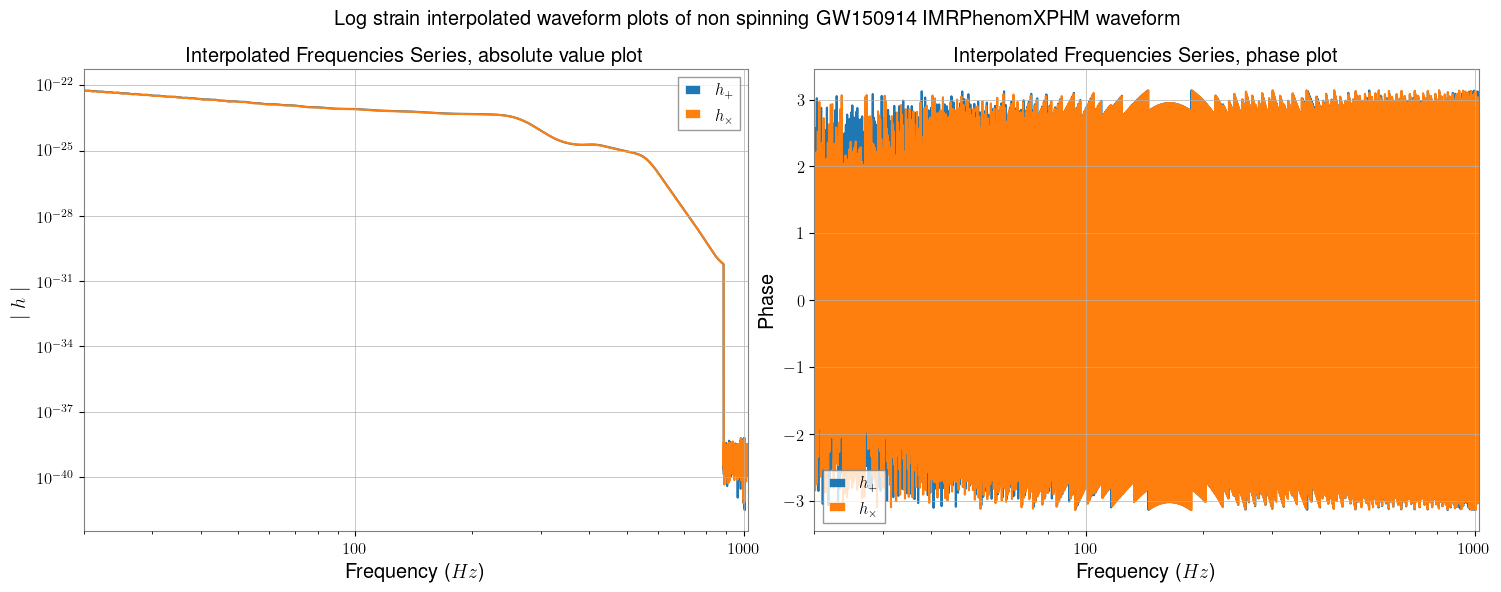

In [26]:
plt.show()

# Let's see if we still see the spurious behaviour of phase in both the interpolations, if we do see it then the problem is not with just TEOBResumS.

# If we don't see this issue, there is a problem with interpolation of TEOBResumS

<font size="4"> Getting the antenna pattern functions from PyCBC </font>

In [28]:
from pycbc.detector import Detector
fp, fc = Detector('L1').antenna_pattern(pars['ra'], pars['dec'], pars['polarization'], pars['trigger_time'])

In [46]:
display(Latex("Antenna pattern function values are : "))
display(Latex("$F_{+}$ = %s"%(fp)))
display(Latex("$F_{\\times}$ = %s"%(fc)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<font size="5"> Multiplying and adding the antenna pattern functions </font>

<font size="4">1. Normal Strain interpolation case </font>

In [47]:
proj_interpolated_hp = fp*interpolated_hp
proj_interpolated_hc = fc*interpolated_hc
tot_proj_interpolated = proj_interpolated_hp + proj_interpolated_hc

In [48]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(frequency_vector, np.abs(proj_interpolated_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(frequency_vector, np.abs(proj_interpolated_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(frequency_vector, np.abs(tot_proj_interpolated), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(frequency_vector, np.angle(proj_interpolated_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(frequency_vector, np.angle(proj_interpolated_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(frequency_vector, np.angle(tot_proj_interpolated), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

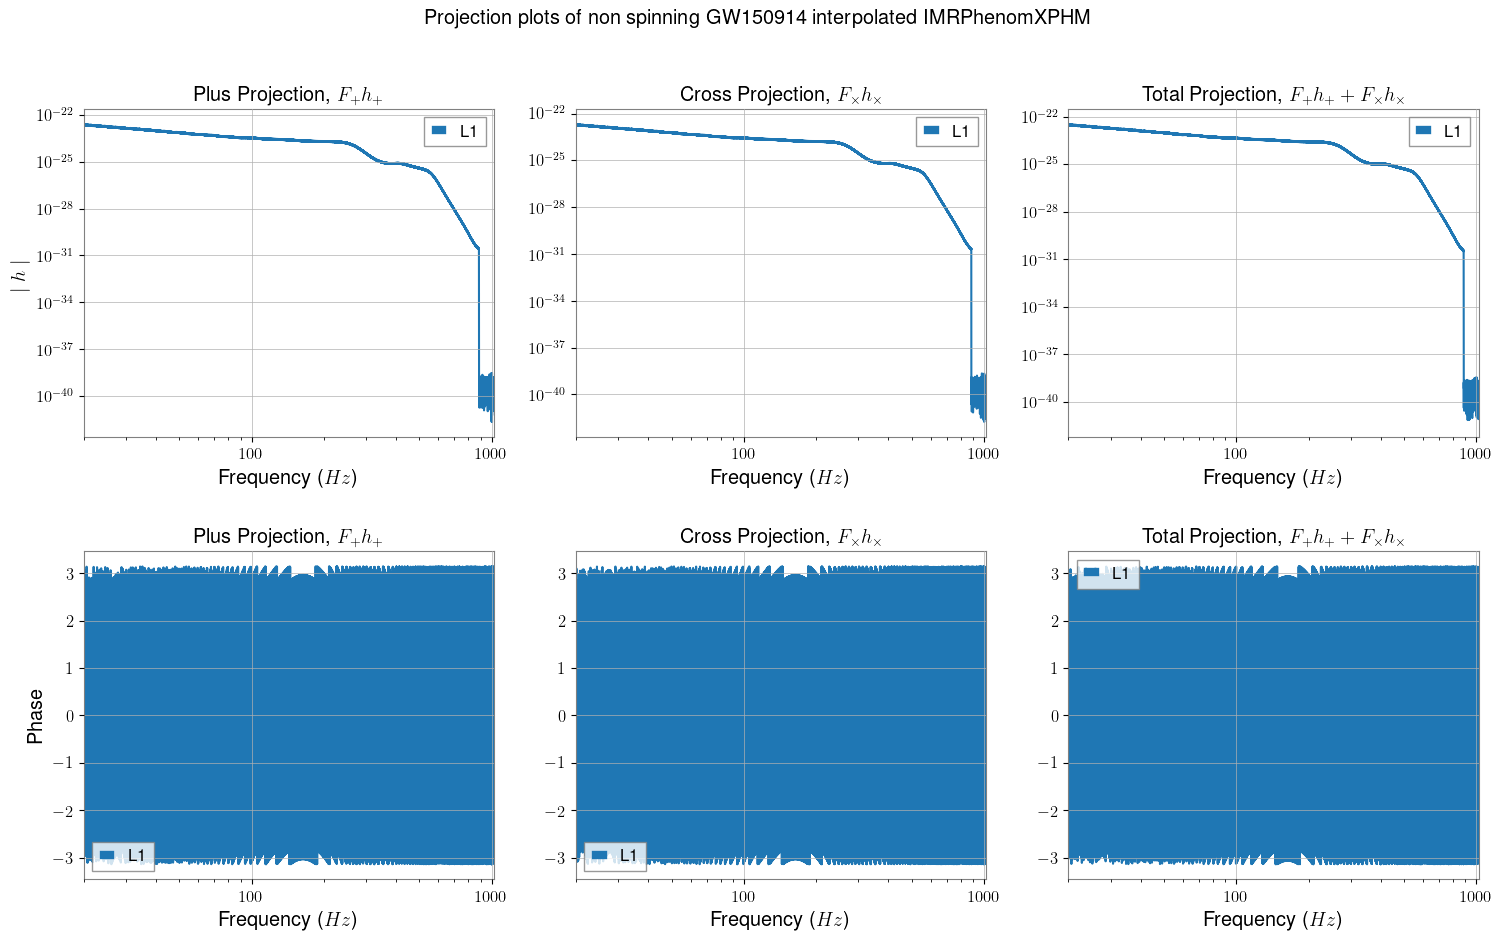

In [49]:
plt.show()

<font size="4">2. Log Strain interpolation case </font>

In [50]:
log_proj_interpolated_hp = fp*log_interpolated_hp
log_proj_interpolated_hc = fc*log_interpolated_hc
log_tot_proj_interpolated = log_proj_interpolated_hp + log_proj_interpolated_hc

In [51]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(frequency_vector, np.abs(log_proj_interpolated_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(frequency_vector, np.abs(log_proj_interpolated_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(frequency_vector, np.abs(log_tot_proj_interpolated), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(frequency_vector, np.angle(log_proj_interpolated_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(frequency_vector, np.angle(log_proj_interpolated_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(frequency_vector, np.angle(log_tot_proj_interpolated), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 log interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

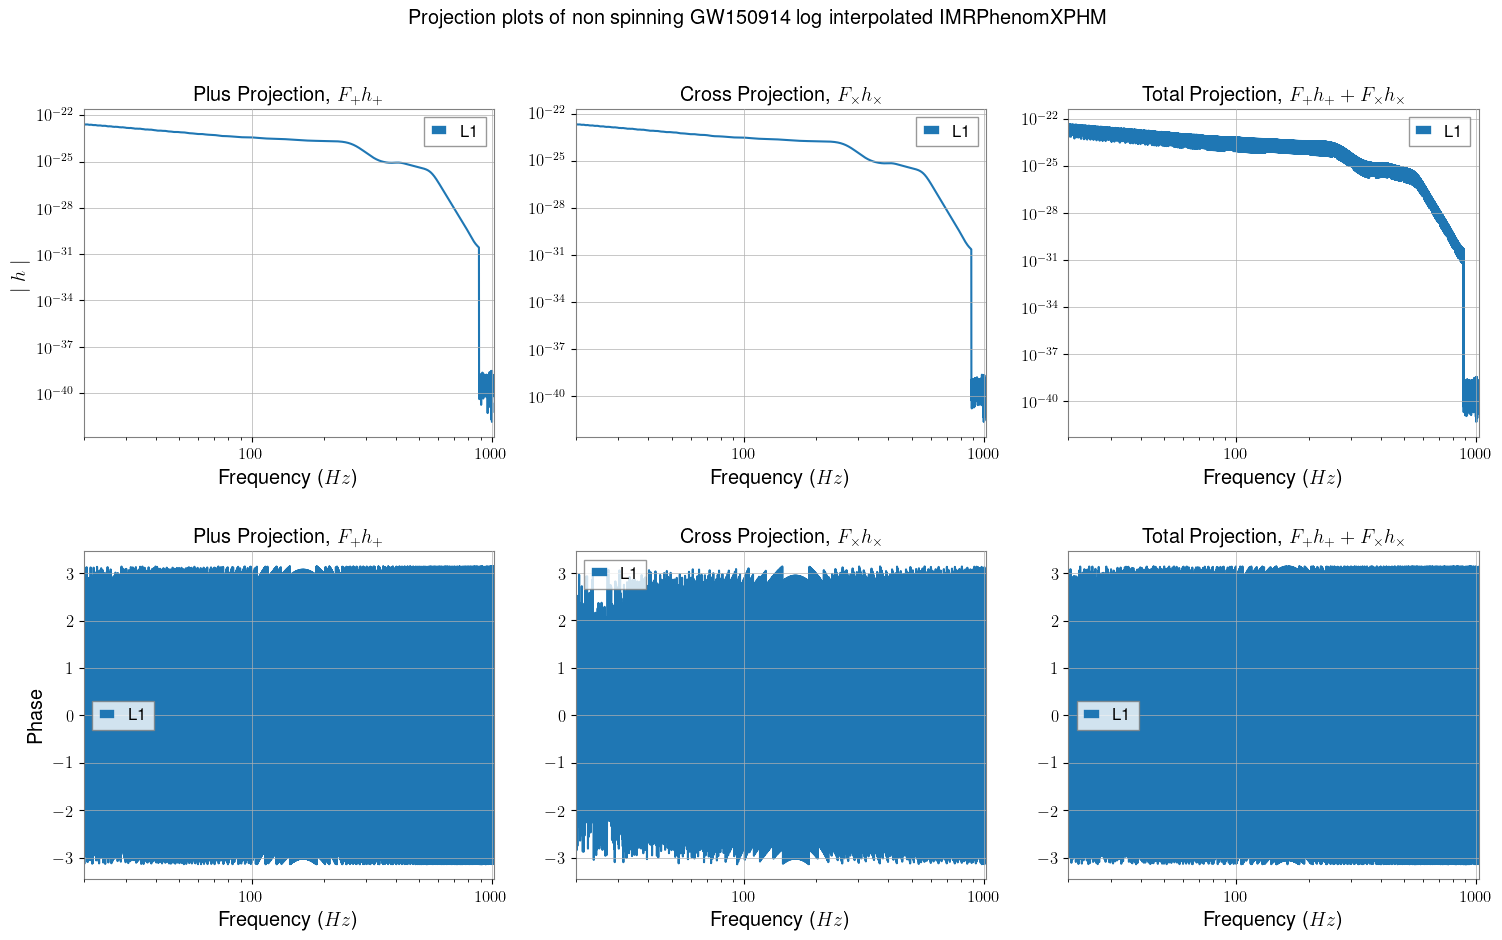

In [52]:
plt.show()